# Coding an LLM Architecture

Things covered:

1. GPT Backbone (a GPT placeholder model to see the overall structure of the model)
2. Tokenizer to tokenize a batch
3. Normalizing activations with layer normalization
4. Implementing a feed forward network with GELU activations
5. Adding Shortcut Connections (a.k.a. Residual Connections or Skip Connections)
6. Connecting attention and linear layers in a transformer block
7. Coding the GPT model
8. Generating text

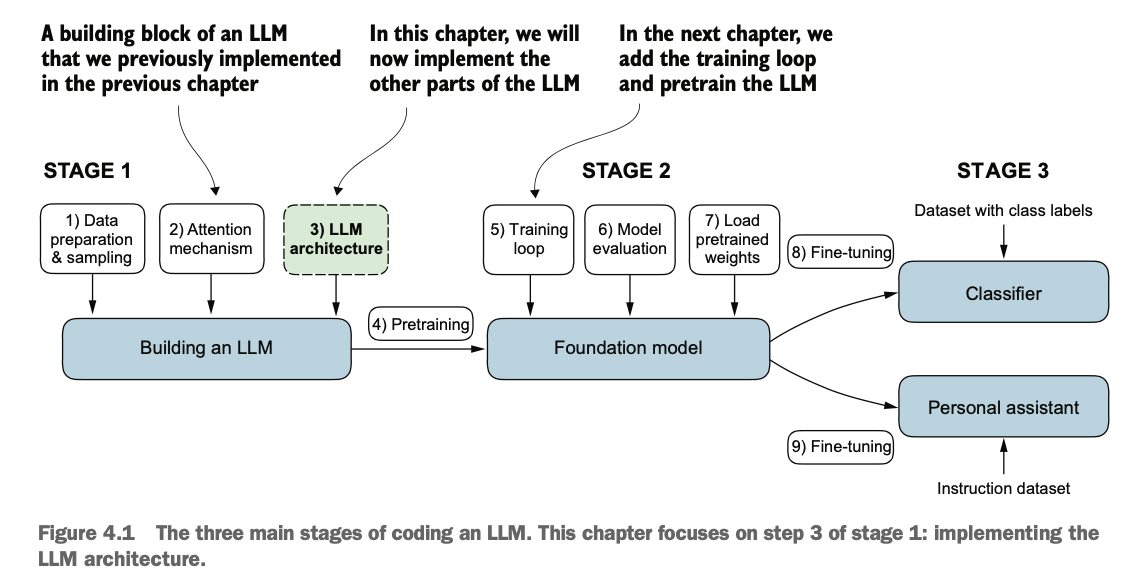

In [60]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768, # Embedding dimension
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
    }

In [61]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

## 1. A GPT Placeholder Model (to see the overall structure of the model)

In [62]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg): # cfg = configuration
        super().__init__()
        self.token_embed = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])] # placeholder
        )
        self.final_norm = DummyLayerNorm(cfg['emb_dim']) # layer norm placeholder
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.token_embed(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module): # placeholder
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module): # placeholder
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

#### ↑ What is happening?

The `DummyGPTModel` class in this code defines a simplified version of a GPT-like model using PyTorch’s neural network module (`nn.Module`). The model architecture in the `DummyGPTModel` class consists of token and positional embeddings, dropout, a series of transformer blocks (`DummyTransformerBlock`), a final layer normalization (`DummyLayerNorm`), and a linear output layer (`out_head`). The configuration is passed in via a Python dictionary, for instance, the `GPT_CONFIG_124M` dictionary created earlier.

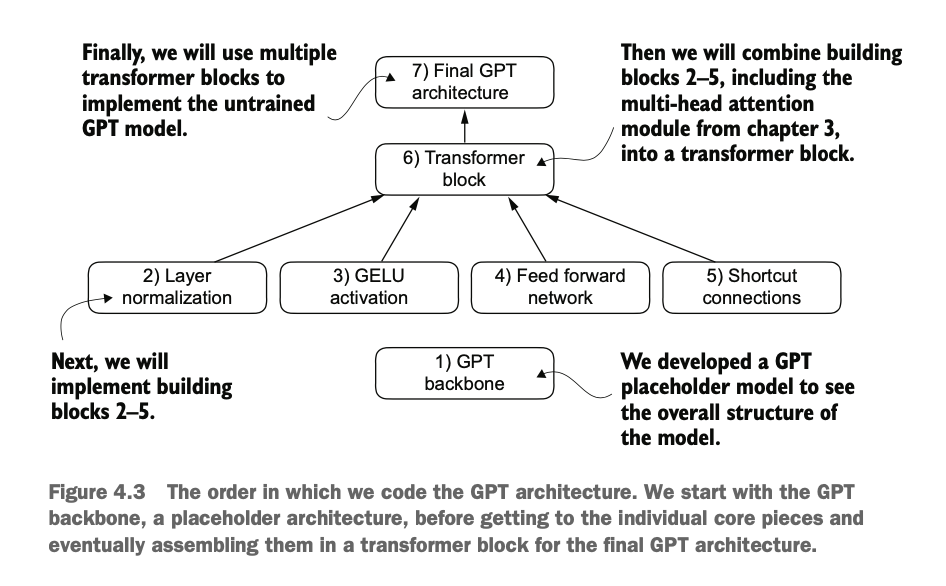

From here, I will prepare the input data and initialize a new GPT model to illustrate its usage.

---

## 2. Tokenizer to tokenize a batch

In [63]:
import tiktoken

In [64]:
tokenizer = tiktoken.get_encoding('gpt2')
batch = []
txt1 = 'Every effort moves you'
txt2 = 'Every day holds a'

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(f"Resulting token IDs:\n{batch}\n\nShape:{batch.shape}")

Resulting token IDs:
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Shape:torch.Size([2, 4])


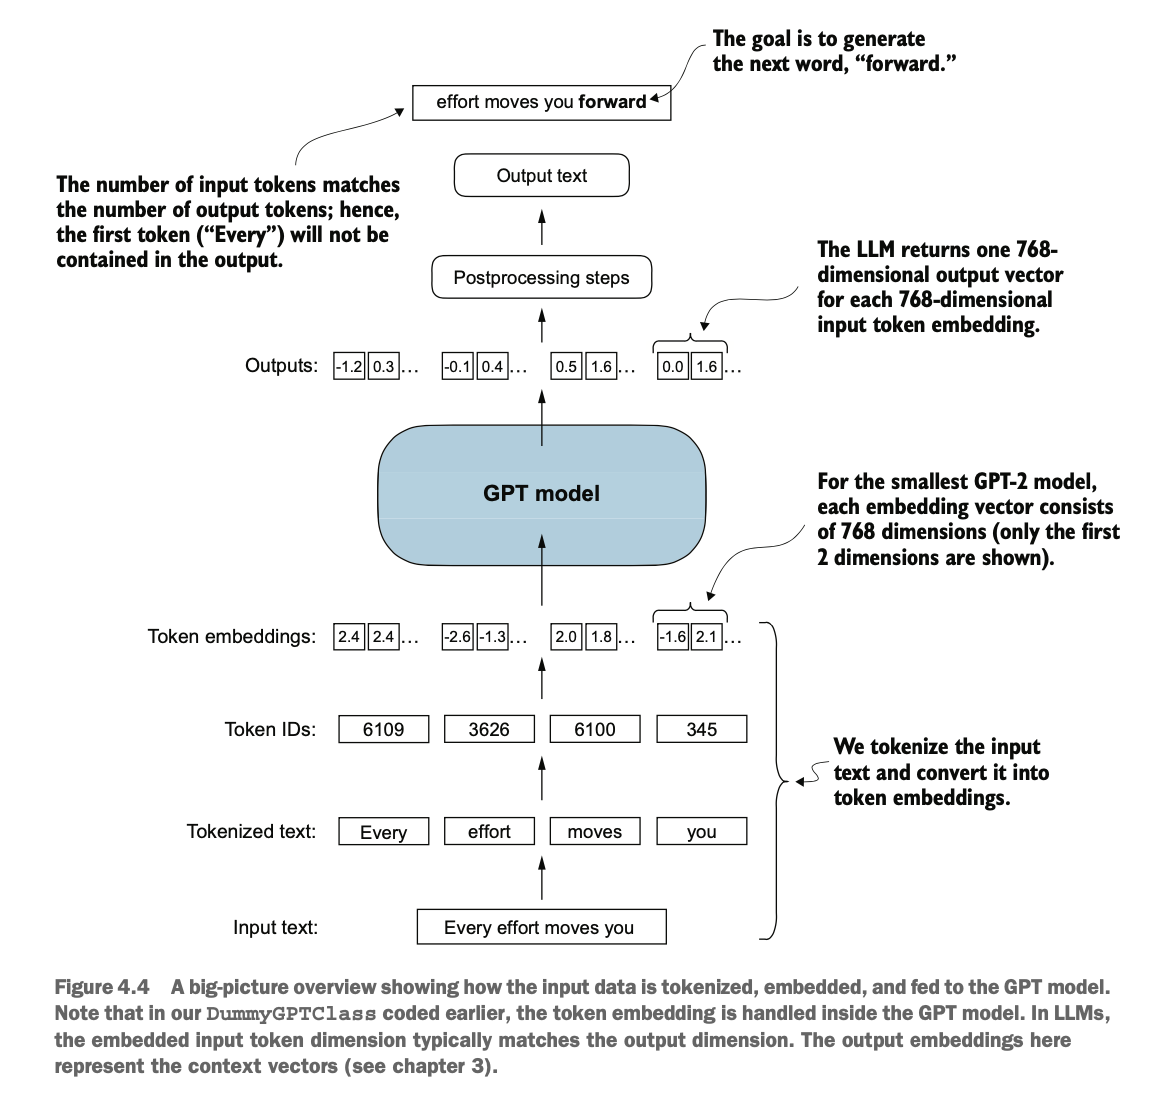

#### Next, initializing a new 124-million parameter `DummyGPTModel` instance and feed the tokenized `batch` to it.

In [65]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
model

DummyGPTModel(
  (token_embed): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): DummyTransformerBlock()
    (1): DummyTransformerBlock()
    (2): DummyTransformerBlock()
    (3): DummyTransformerBlock()
    (4): DummyTransformerBlock()
    (5): DummyTransformerBlock()
    (6): DummyTransformerBlock()
    (7): DummyTransformerBlock()
    (8): DummyTransformerBlock()
    (9): DummyTransformerBlock()
    (10): DummyTransformerBlock()
    (11): DummyTransformerBlock()
  )
  (final_norm): DummyLayerNorm()
  (out_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [66]:
logits = model(batch)
print(f'Output shape: {logits.shape}\nOutput:\n{logits}')

Output shape: torch.Size([2, 4, 50257])
Output:
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


---

## 3. Normalizing activations with layer normalization

Starting with a little bit of detour. Doing a simple example to understand the concept of layer normalization.

nn.Sequential: A sequential container. Modules will be added to it in the order they are passed in the constructor. E.g., `nn.Sequential(A, B, C)` will add modules A, B, and C to the container in that order.

In [67]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(f"batch_example's shape: {batch_example.shape}\n\nOut's shape: {out.shape}\nOut:\n{out}")

batch_example's shape: torch.Size([2, 5])

Out's shape: torch.Size([2, 6])
Out:
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


#### ↑ What is happening?
I'm creating a simple neural network with a single linear layer and a ReLU activation function. The input to the network is a tensor of shape `(batch_size, 5)`, and the output is a tensor of shape `(batch_size, 6)`. The linear layer transforms the input tensor from 5 to 6 dimensions, and the ReLU activation function applies the element-wise ReLU function to the output of the linear layer.

`nn.Sequential(nn.Linear(5, 6), nn.ReLU())` means that the input tensor is first passed through the linear layer and then through the ReLU activation function. The `nn.Linear(5, 6)` module represents a linear transformation of the input tensor from 5 to 6 dimensions, and the `nn.ReLU()` module applies the ReLU activation function to the output of the linear layer.

Let's check the mean and variance of the output tensor before and after applying layer normalization.

In [68]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


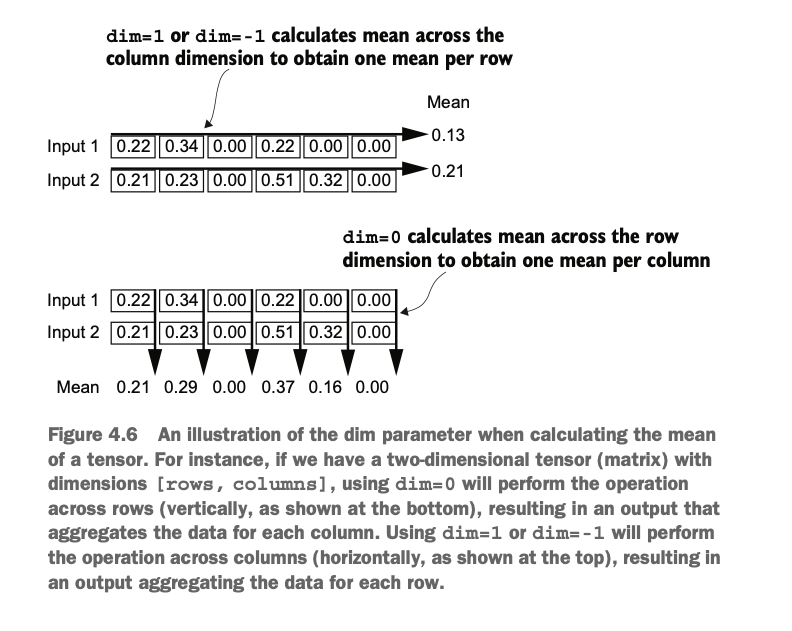

Now applying layer normalization to the layer output.

In [69]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [70]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [71]:
# layernorm class

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # epsilon, added to the variance to prevent division by zero during normalization
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # unbiased = False means dividing by `n` and not `n-1`
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

#### ↑ What is happening?

`norm_x = (x - mean) / torch.sqrt(var + self.eps)` is the formula for layer normalization. Here, x is the input tensor, mean is the mean of the input tensor, var is the variance of the input tensor, and self.eps is a small value added to the variance to avoid division by zero.

Mathematically: $$ \text{norm}(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} $$ where:

- x is the input tensor
- μ is the mean of the input tensor
- σ is the standard deviation of the input tensor
- ε is a small value added to the variance to avoid division by 

Also, the class is returning `self.scale * norm_x + self.shift`.

`Self.scale` (γ) scales the normalized activations $x$ and `self.shift` (β) shifts the scaled activations. This is done to allow the model to learn the optimal scaling and shifting parameters for the normalized activations.

The formula for layer normalization with learnable parameters γ and β is given by:

$$ \text{LayerNorm}(x) = \gamma \left( \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \right) + \beta $$

which can be simplified to:

$$ \text{LayerNorm}(x) = \gamma \left [\text{norm}(x) \right] + \beta $$

where γ and β are learnable parameters.

In [72]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


---

## 4. Implementing a feed forward network with GELU activations

Historically, the ReLU activation function has been commonly used in deep learning due to its simplicity and effectiveness across various neural network architectures. However, in LLMs, several other activation functions are employed beyond the traditional ReLU. Two notable examples are GELU (Gaussian error linear unit) and SwiGLU (Swish-gated linear unit).

The exact version of the GELU activation function used in the LLM architecture is:

$$ GELU(x) = x. phi(x) $$

where:

- x is the input tensor
- phi(x) is the Gaussian error linear unit function, i.e., the cumulative distribution function of the standard Gaussian distribution

There's a computationally cheaper approximation of the GELU activation function that is often used in practice (including in the original GPT-2 model). This approximation is given by:

$$ \text{GELU}(x) = 0.5x(1 + \text{tanh}(\sqrt{{2/\pi}}(x + 0.044715x^3))) $$

In code:

In [73]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2/torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))

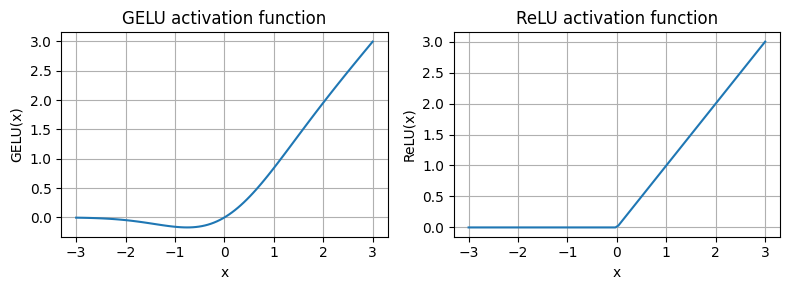

In [74]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch. linspace(-3, 3, 100) # 100 datapoints between -3 and 3
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

↑ As seen in the resulting plot, ReLU (right) is a piecewise linear function that outputs the input 
directly if it is positive; otherwise, it outputs zero. GELU (left) is a smooth, nonlinear function that approximates ReLU but with a non- zero gradient for almost all negative values (except at approximately x = –0.75).

### Using GELU activation function in a feed forward network

In [75]:
GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [76]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']), # linear layer
            GELU(), # gelu activation
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim']), # linear layer
        )
    
    def forward(self, x):
        return self.layers(x)

In [77]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
out, out.shape

(tensor([[[ 0.1238,  0.0457,  0.0939,  ...,  0.1107,  0.0167, -0.1992],
          [ 0.1574, -0.0282,  0.0049,  ...,  0.0026,  0.1120, -0.1075],
          [ 0.1184, -0.0052,  0.0839,  ...,  0.1662,  0.0112, -0.1685]],
 
         [[ 0.1302,  0.0630,  0.1050,  ...,  0.1439,  0.0562, -0.1128],
          [ 0.1249, -0.0073,  0.1022,  ...,  0.0417,  0.0381, -0.0828],
          [ 0.0494,  0.0654,  0.0347,  ...,  0.0701,  0.0793, -0.1810]]],
        grad_fn=<ViewBackward0>),
 torch.Size([2, 3, 768]))

#### ↑ What is happening with the FeedForwardNetwork class?

Basically creating a feed forward network with 2 linear layers and a GELU activation function in between.

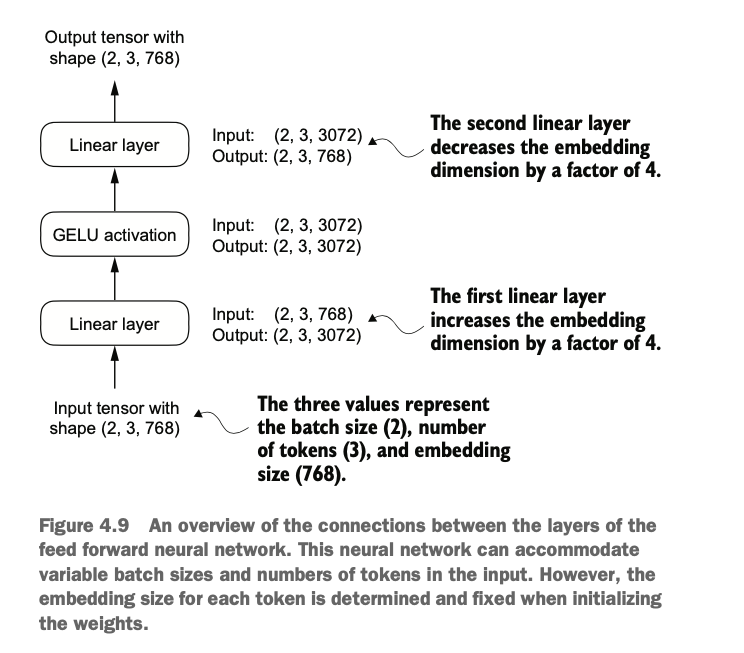

---

## 5. Adding Shortcut Connections (a.k.a. Residual Connections or Skip Connections)

From Raschka's LLM book:
> A shortcut connection creates an alternative, shorter path for the gradient to flow through the network by skipping one or more layers, which is achieved by adding the output of one layer to the output of a later layer. This is why these connections are also known as skip connections. They play a crucial role in preserving the flow of gradients during the backward pass in training.

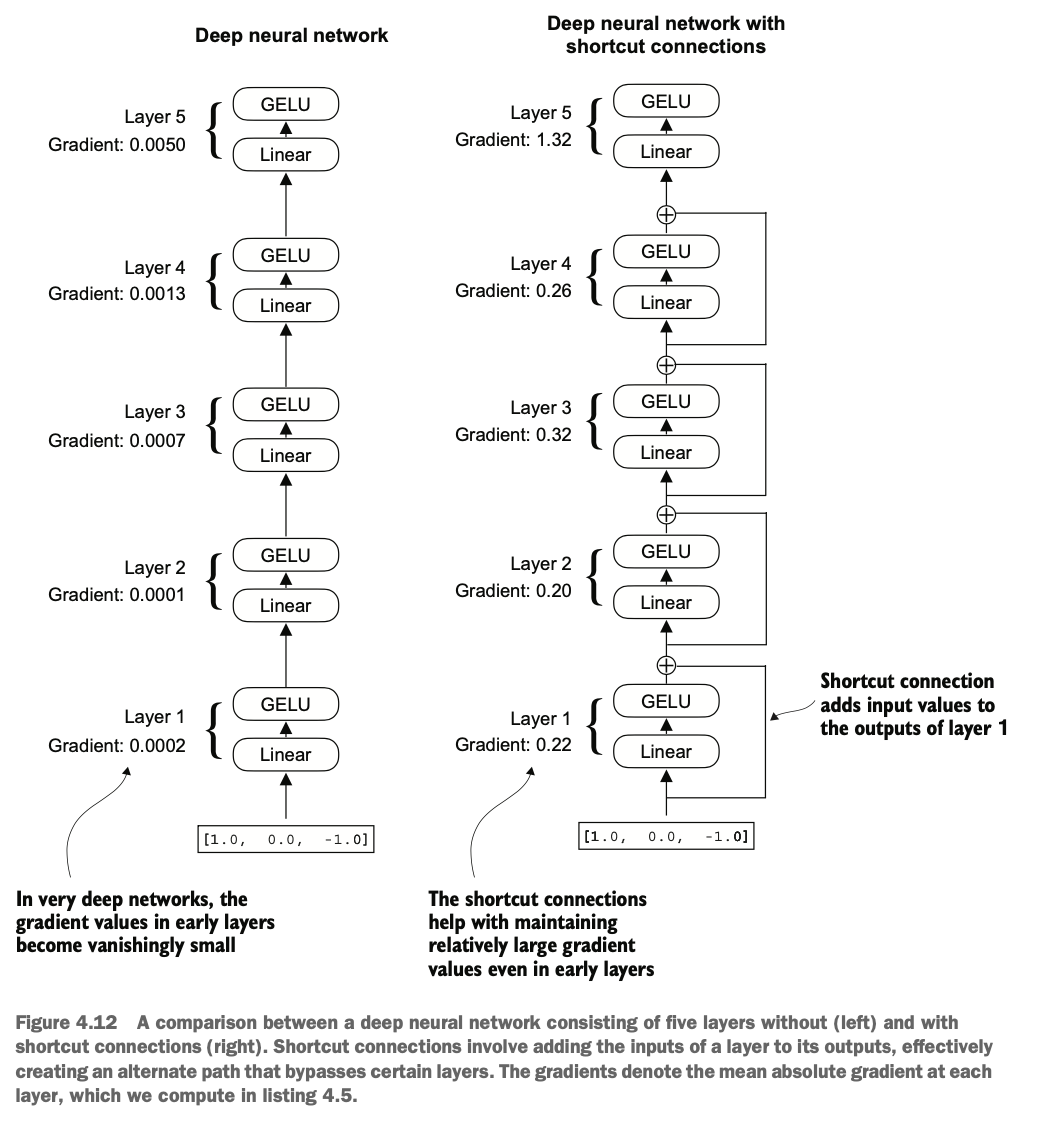

### A neural network to illustrate shortcut connections

In [78]:
class ExampleDeepNN(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])
    
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)

            # if self.use_shortcut is True, goes to x.shape == ..., if False, skips it altogether.
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

### Initializing a nn without shortcut connections

In [79]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)

model_without_shortcut = ExampleDeepNN(
    layer_sizes, use_shortcut=False
)

In [80]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()
    
    # named_parameters documentation: https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.named_parameters
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [81]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


#### ↑ What is happening?

The gradient is vanishing as it backpropagates through the network, which can lead to slower convergence or even prevent the network from learning effectively. This is known as the vanishing gradient problem.

### Trying it with shortcut connections

In [82]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNN(layer_sizes, use_shortcut=True)

print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.2216978669166565
layers.1.0.weight has gradient mean of 0.20694100856781006
layers.2.0.weight has gradient mean of 0.3289698660373688
layers.3.0.weight has gradient mean of 0.2665731906890869
layers.4.0.weight has gradient mean of 1.3258538246154785


#### ↑ What is happening?

The last layer (layers.4) still has a larger gradient than the other layers. However, the gradient value stabilizes as we progress toward the first layer (layers.0) and doesn’t shrink to a vanishingly small value. This is because the shortcut connections provide an alternative path for the gradient to flow through the network, which helps preserve the gradient magnitude during backpropagation. 

In conclusion, the shortcut connections help mitigate the vanishing gradient problem by providing an alternative path for the gradient to flow through the network, which can lead to faster convergence and more effective learning.

---

## 6. Connecting attention and linear layers in a transformer block

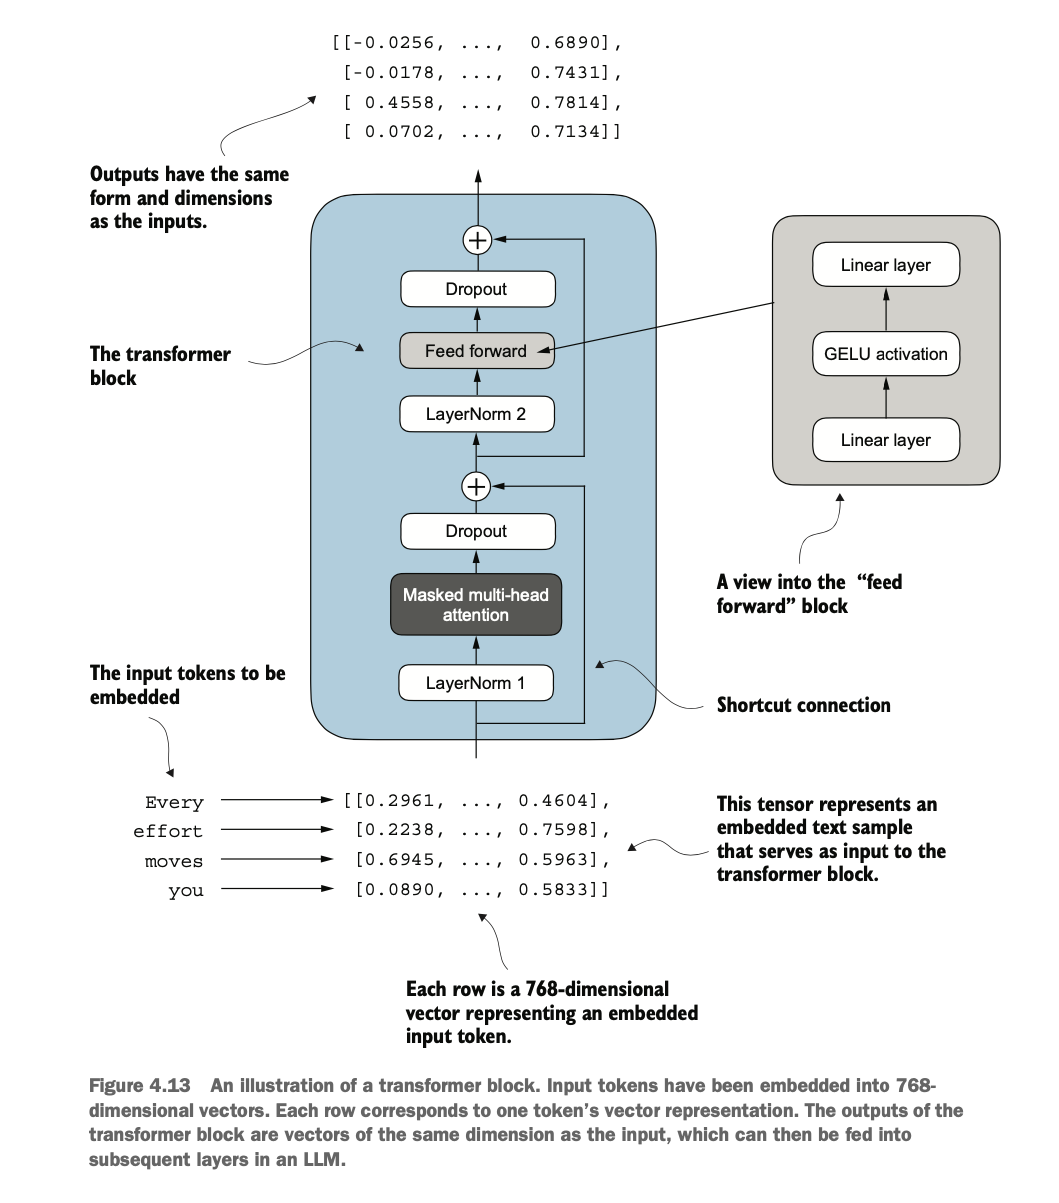

In [83]:
from multihead import MultiHeadAttention

GPT_CONFIG_124M

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [84]:
class TransformerBlock(nn.Module):
    # define init, super
    def __init__(self, cfg):
        super().__init__()
        # define self attention
        self.attn = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )

        # define feed forward
        self.feed_forward=FeedForward(cfg)
        
        # 2 layer normalizations
        self.norm1=LayerNorm(cfg["emb_dim"]) # for attn block
        self.norm2=LayerNorm(cfg["emb_dim"]) # for feed forward block
        
        # drop shortcut
        self.drop_shortcut=nn.Dropout(cfg["drop_rate"])

    # def forward
    def forward(self, x):

        # shortcut connection for attn block
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.feed_forward(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

#### ↑ What is happening?

The code defines a TransformerBlock class in PyTorch that includes a multi-head attention mechanism (MultiHeadAttention) and a feed forward network (`FeedForward`), both configured based on a provided configuration dictionary (`cfg`), such as `GPT_CONFIG_124M`.

Layer normalization (`LayerNorm`) is applied before each of these two components, and dropout is applied after them to regularize the model and prevent overfitting. This is also known as *__Pre-LayerNorm__*. Older architectures, such as the original transformer model, applied layer normalization after the self-attention and feed forward networks instead, known as *__Post-LayerNorm__*, <u>*which often leads to worse training dynamics*</u>.

In [85]:
# instantiating a transformer block

torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


---

## 7. Coding the GPT model

I had a DummyGPTModel class earlier to see the overall structure of the model, which consisted of DummyTransformerBlock and DummyLayerNorm classes as placeholders. Now, I will code the fully working version of the original 124-million parameter version of GPT-2 by replacing the placeholders with the actual TransformerBlock and LayerNorm classes.

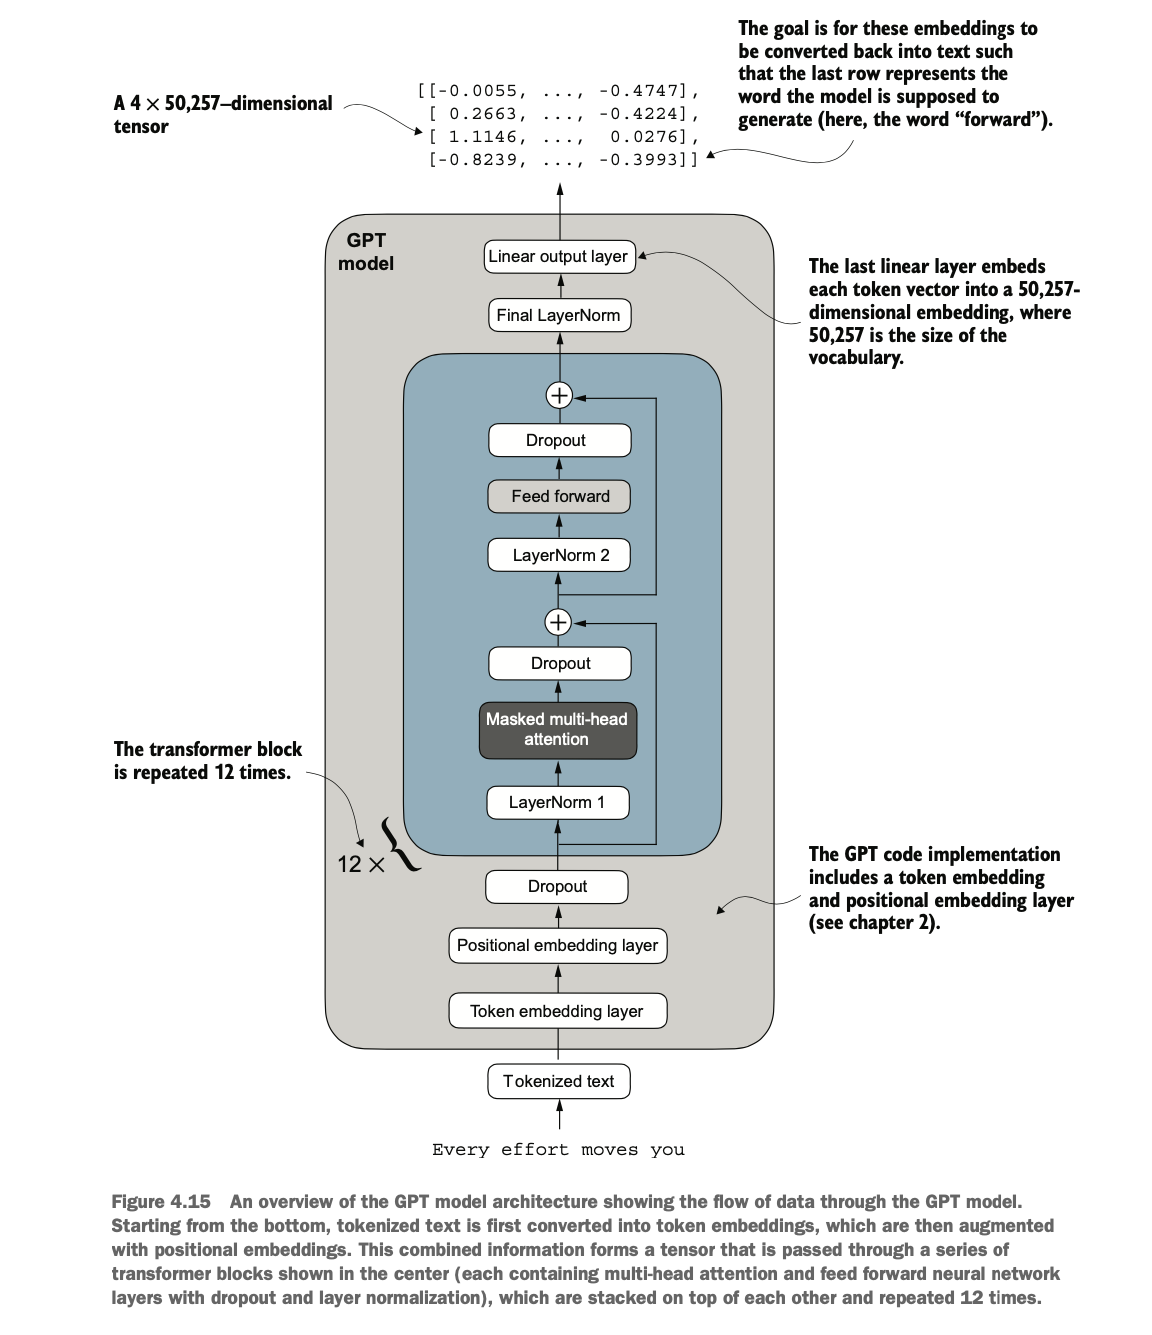

From the figure above, I can see that the transformer block is repeated 12 times (since the model has 12 layers), which is specificed via the `n_layers` entry in the `GPT_CONFIG_124M` configuration dictionary. This transform block is repeated 48 times in the 1.5-billion parameter version of GPT-2.

The output of the final transformer block is passed through a layer normalization before reaching the linear output layer (`out_head`), which is a linear transformation of the output tensor to the vocabulary size (e.g., 50,257 for the GPT-2 model) to predict the next token in the sequence.

Coding the GPT model architecture:

In [86]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_embed = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])] # real transformer block
        )
        self.final_norm = LayerNorm(cfg['emb_dim']) # real layer norm class
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.token_embed(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [87]:
tokenizer = tiktoken.get_encoding('gpt2')
batch = []
txt1 = 'Every effort moves you'
txt2 = 'Every day holds a'

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(f"Resulting token IDs:\n{batch}\n\nShape:{batch.shape}")

Resulting token IDs:
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Shape:torch.Size([2, 4])


In [88]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)

print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


#### ↑ What is happening?

Can see that the output tensor has the shape `[2, 4, 50257]` where 2 is the batch size (I passed 2 input texts), 4 is the sequence length (4 tokens per each text/sequence), and 50257 - the last dimension - is the vocabulary size.

### Further analyzing the model architecture

numel() method, short for “number of elements,” returns the total number of elements in the input tensor. This is equivalent to the product of the tensor’s dimensions.

In [89]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [90]:
print("Token embedding layer shape:", model.token_embed.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [91]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


In [92]:
# computing the memory requirements for the GPTModel object

total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


#### Exercise 1:

Calculate and compare the number of parameters that are contained in the feed forward module and those that are contained in the multi-head attention module.

GPTBlock class:

```python
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_embed = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])] # real transformer block
        )
        self.final_norm = LayerNorm(cfg['emb_dim']) # real layer norm class
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.token_embed(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
```

In [93]:
total_params_ff = sum(p.numel() for p in block.feed_forward.parameters())

print(f"Number of ff module parameters in each Transformer block: {total_params_ff:,}")

# parameters contained in the multihead attention module

total_params_attn = sum(p.numel() for p in block.attn.parameters())

print(f"Number of attention module parameters in each Transformer Block: {total_params_attn:,}")

print(f"\nTotal number of:\nFeed Forward Module Parameters: {total_params_ff * 12:,}\nAttention Parameters: {total_params_attn * 12:,}")

Number of ff module parameters in each Transformer block: 4,722,432
Number of attention module parameters in each Transformer Block: 2,360,064

Total number of:
Feed Forward Module Parameters: 56,669,184
Attention Parameters: 28,320,768


In [94]:
# A more intuitive way to do the parameter calculation:

total_params_ff2 = sum(
    sum(p.numel() for p in block.feed_forward.parameters())
    for block in model.trf_blocks
)

total_params_attn2 = sum(
    sum(p.numel() for p in block.attn.parameters())
    for block in model.trf_blocks
)

print(f'Feed Forward module parameters: {total_params_ff:,}\nAttention parameters: {total_params_attn2:,}')

Feed Forward module parameters: 4,722,432
Attention parameters: 28,320,768


#### Exercise 2
We initialized a 124-million-parameter GPT model, which is known as “GPT-2 small.” Without making any code modifications besides updating the configuration file, use the GPTModel class to implement GPT-2 medium (using 1,024-dimensional embed

dings, 24 transformer blocks, 16 multi-head attention heads), GPT-2 large (1,280-dimensional embeddings, 36 transformer blocks, 20 multi-head attention heads), and GPT-2 XL (1,600-dimensional embeddings, 48 transformer blocks, 25 multi-head attention heads). As a bonus, calculate the total number of parameters in each GPT model.

##### Starting with GPT-2 medium:

In [95]:
GPT_2_MEDIUM_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 1024, # Embedding dimension
    "n_heads": 16, # Number of attention heads
    "n_layers": 24, # Number of layers / transformer blocks
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
    }

In [96]:
tokenizer = tiktoken.get_encoding('gpt2')
batch = []
txt1 = 'Every effort moves you'
txt2 = 'Every day holds a'

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(f"Resulting token IDs:\n{batch}\n\nShape:{batch.shape}")

Resulting token IDs:
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Shape:torch.Size([2, 4])


In [97]:
model_gpt2_m = GPTModel(GPT_2_MEDIUM_CONFIG)

In [98]:
total_params_gpt2_m = sum(p.numel() for p in model_gpt2_m.parameters())
print(f"Total number of parameters: {total_params_gpt2_m:,}")

total_params_gpt2_medium = (
    total_params_gpt2_m - sum(p.numel() for p in model_gpt2_m.out_head.parameters())
)
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2_medium:,}"
)

Total number of parameters: 406,212,608
Number of trainable parameters considering weight tying: 354,749,440


---
## 8. Generating Text

The current GPTModel implementation outputs tensors with shape `[batch_size, num_token, vocab_size]`. Now the question is: How does a GPT model go from these output tensors to the generated text?

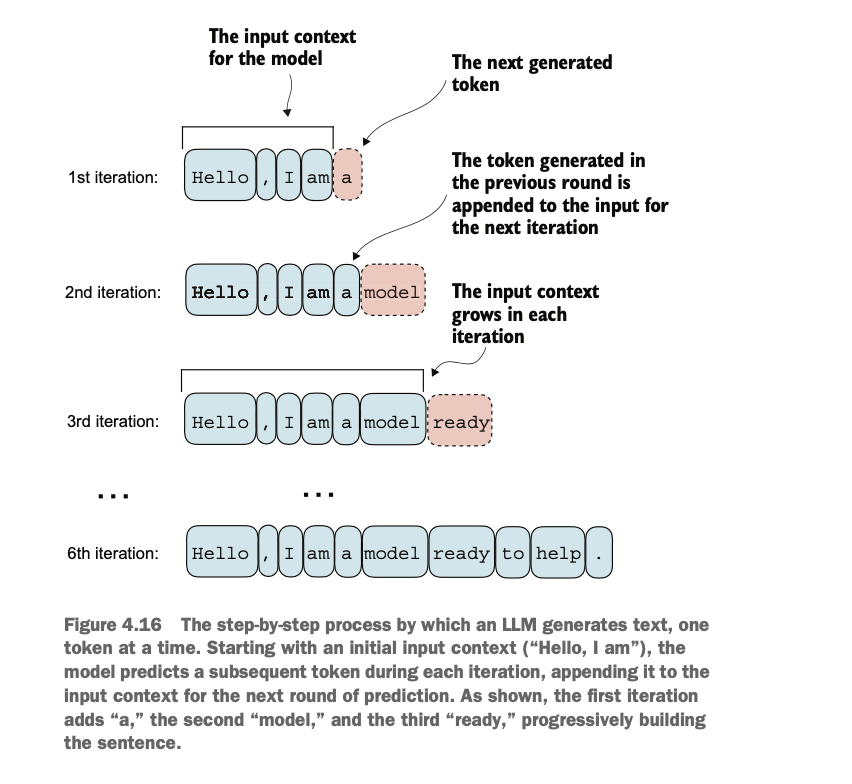

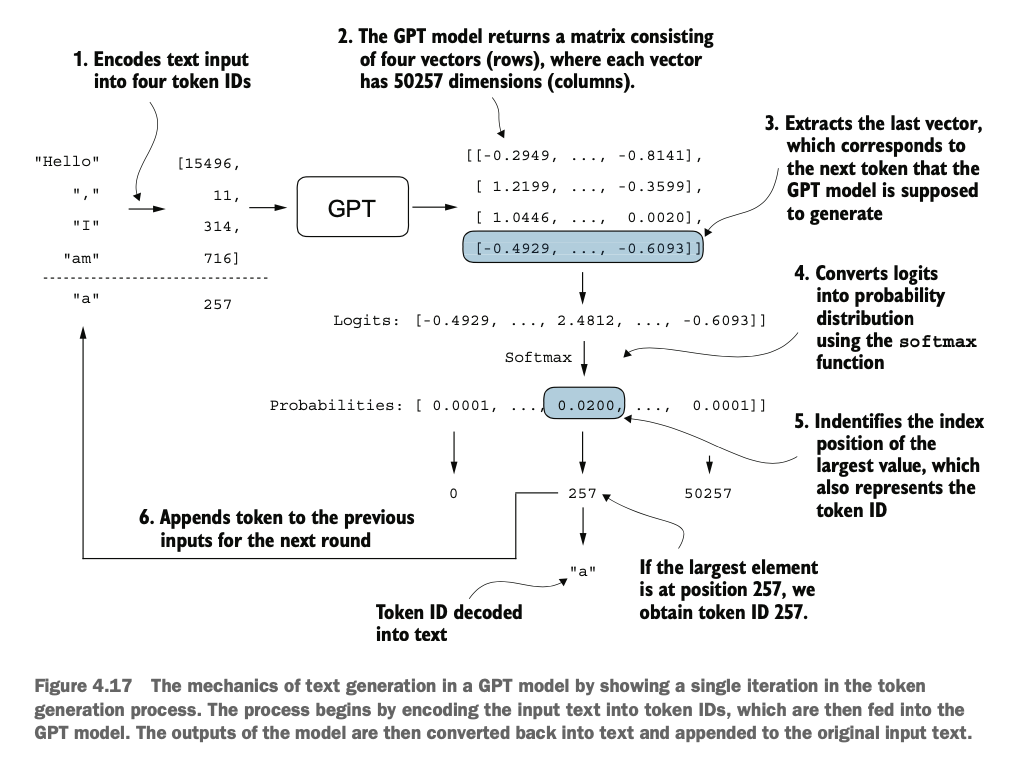

### A function for the gpt model to generate text

torch.argmax(input, dim, keepdim=False) returns the **indices** of the maximum value of all elements in the input tensor.
Example:

```python
import torch
a = torch.randn(4, 4)
print(a) # suppose it gives: tensor([[ 0.1427, -0.3495, -0.7326,  0.0036],
print(torch.argmax(a)) # tensor(0) (as in the first row, the first element is the maximum)
```

Documentation: https://pytorch.org/docs/stable/generated/torch.argmax.html

In [99]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):

        # Crops current context if it exceeds the supported context size, e.g.,
        # if LLM supports only 5 tokens, and the context size is 10, then only
        # the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        # focusing on the last step. (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :] 

        probas = torch.softmax(logits, dim=-1) # has shape (batch, vocab_size)
        idx_next = torch.argmax(probas,  dim=-1, keepdim=True) # has shape (batch, 1)

        # appending sampled index to the ongoing sequence, where idx has a
        # shape (batch, n_tokens+1)
        idx = torch.cat((idx, idx_next), dim=1) 

    return idx

In [100]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0) # adds batch dimension
print("shape of encoded tensor:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
shape of encoded tensor: torch.Size([1, 4])


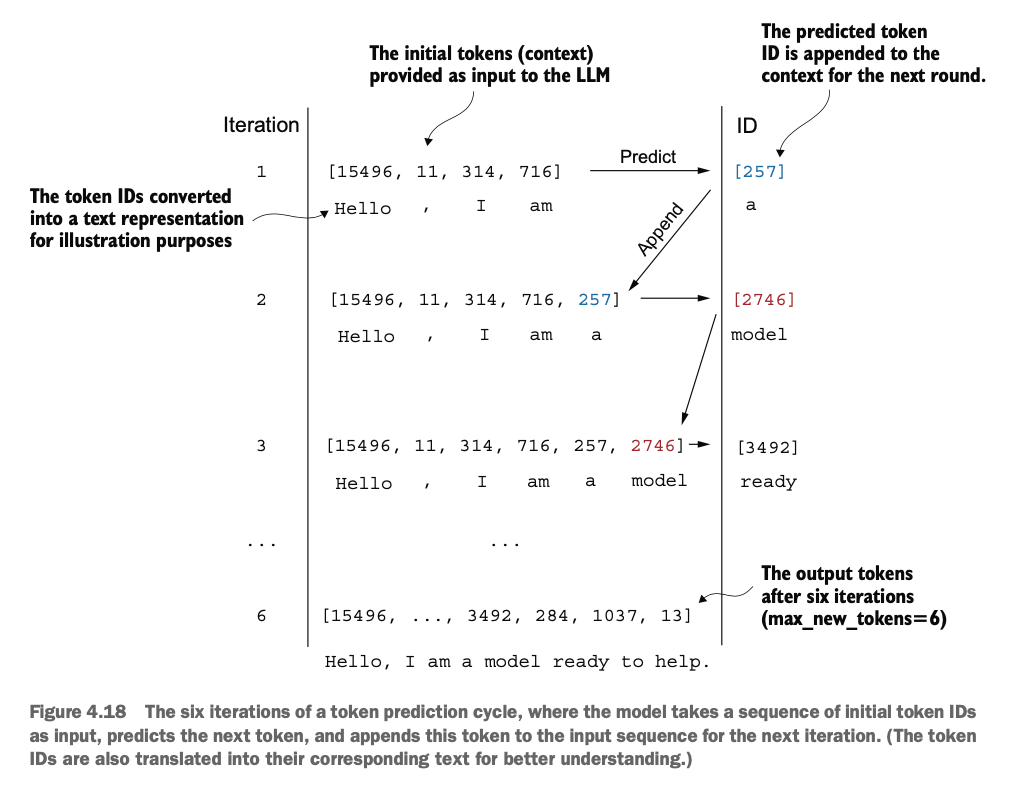

In [115]:
model.eval() # disables dropout as we haven't yet trained it
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [116]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
decoded_text

'Hello, I am Featureiman Byeswickattribute argue'